# 1. Evaluating supervised learners in CapyMOA

This notebook further explores **high-level evaluation functions**, **Data Abstraction** and **Classifiers**

* **High-level evaluation functions**
    * We demonstrate how to use ```prequential_evaluation()``` and how to further encapsulate prequential evaluation using ```prequential_evaluation_multiple_learners```
    * We also discuss particularities about how these evaluation functions relate to how research has developed in the field, and how evaluation is commonly performed and presented.

* **Supervised Learning**
    * We clarify important information concerning the usage of **Classifiers** and their predictions
    * We added some examples using **Regressors**, which highlight the fact that the evaluation is identical to **Classifiers** (i.e. same high-level evaluation functions)
 
---

*More information about CapyMOA can be found in* https://www.capymoa.org

**last update on 25/07/2024**

## 1. The difference between Evaluators

* The following example implements an **while loop** that updates a ```ClassificationWindowedEvaluator``` and a ```ClassificationEvaluator``` for the same learner. 
* The ```ClassificationWindowedEvaluator``` update the metrics according to tumbling windows which 'forgets' old correct and incorrect predictions. This allows us to observe how well the learner performs on shorter windows. 
* The ```ClassificationEvaluator``` updates the metrics taking into account all the correct and incorrect predictions made. It is useful to observe the overall performance after processing hundreds of thousands of instances.

* **Two important points**:
    1. Regarding **window_size** in ```ClassificationEvaluator```: A ```ClassificationEvaluator``` also allow us to specify a window size, but it only controls the frequency at which cumulative metrics are calculated.
    2. If we access metrics directly (not through ```metrics_per_window()```) in ```ClassificationWindowedEvaluator``` we will be looking at the metrics corresponding to the last window.
 
For further insight into the specifics of the Evaluators, please refer to the documentation: https://www.capymoa.org

In [1]:
# This cell is hidden on capymoa.org. See docs/contributing/docs.rst
from util.nbmock import mock_datasets, is_nb_fast

if is_nb_fast():
    mock_datasets()

In [2]:
from capymoa.datasets import Electricity
from capymoa.evaluation import ClassificationWindowedEvaluator, ClassificationEvaluator
from capymoa.classifier import AdaptiveRandomForestClassifier

stream = Electricity()

ARF = AdaptiveRandomForestClassifier(schema=stream.get_schema(), ensemble_size=10)

# The window_size in ClassificationWindowedEvaluator specifies the amount of instances used per evaluation
windowedEvaluatorARF = ClassificationWindowedEvaluator(
    schema=stream.get_schema(), window_size=4500
)
# The window_size ClassificationEvaluator just specifies the frequency at which the cumulative metrics are stored
classificationEvaluatorARF = ClassificationEvaluator(
    schema=stream.get_schema(), window_size=4500
)

while stream.has_more_instances():
    instance = stream.next_instance()
    prediction = ARF.predict(instance)
    windowedEvaluatorARF.update(instance.y_index, prediction)
    classificationEvaluatorARF.update(instance.y_index, prediction)
    ARF.train(instance)

# Showing only the 'classifications correct (percent)' (i.e. accuracy)
print(
    "[ClassificationWindowedEvaluator] Windowed accuracy reported for every window_size windows"
)
print(windowedEvaluatorARF.accuracy())

print(
    f"[ClassificationEvaluator] Cumulative accuracy: {classificationEvaluatorARF.accuracy()}"
)
# We could report the cumulative accuracy every window_size instances with the following code, but that is normally not very insightful.
# display(classificationEvaluatorARF.metrics_per_window())

[ClassificationWindowedEvaluator] Windowed accuracy reported for every window_size windows
[89.57777777777778, 89.46666666666667, 90.2, 89.71111111111111, 88.68888888888888, 88.48888888888888, 87.6888888888889, 88.88888888888889, 89.28888888888889, 91.06666666666666]
[ClassificationEvaluator] Cumulative accuracy: 89.32953742937853


## 2. High-level evaluation functions

In CapyMOA, for supervised learning, there is one primary evaluation function designed to handle the manipulation of Evaluators, i.e. the `prequential_evaluation()`. This function streamline the process, ensuring users need not directly update them. Essentially, this function execute the evaluation loop and update the relevant Evaluators:

`prequential_evaluation()` utilises `ClassificationEvaluator` and `ClassificationWindowedEvaluator`

Previously, CapyMOA included two other functions: `cumulative_evaluation()` and `windowed_evaluation()`. However, since `prequential_evaluation()` incorporates the functionality of both we decided to remove those functions and focus on `prequential_evaluation()`.
It's important to note that `prequential_evaluation()` is applicable to both `Regression` and `Prediction Intervals` besides `Classification`. The functionality and interpretation remain the same across these cases, but the metrics differ.

**Result of a high-level function**

* The return from `prequential_evaluation()` is a `PrequentialResults` object which provides access to the `cumulative` and `windowed` metrics as well as some other metrics (like wall-clock and cpu time).

**Common characteristics for all high-level evaluation functions**

* `prequential_evaluation()` specify a `max_instances` parameter, which by default is `None`. Depending on the source of the data (e.g. a real stream or a synthetic stream) the function will never stop! The intuition behind this is that Streams are infinite, we process them as such. Therefore, it is a good idea to specify `max_instances` unless you are using a snapshot of a stream (i.e. a `Dataset` like `Electricity`)

**Evaluation practices in the literature (and practice)**

Interested readers might want to peruse section **6.1.1 Error Estimation** from [Machine Learning for Data Streams](https://moa.cms.waikato.ac.nz/book-html/) book. We further expand the relationships between the literature and our evaluation functions in the documentation: https://www.capymoa.org

### 2.1 prequential_evaluation()

A `prequential_evaluation()` performs a windowed evaluation and a cumulative evaluation at once. Internally, it maintains a `ClassificationWindowedEvaluator` (for the windowed metrics) and ```ClassificationEvaluator``` (for the cumulative metrics). This allows us to have access to the **cumulative** and **windowed** results without running two separate evaluation functions. 

* The results returned from ```prequential_evaluation()``` allows accessing the Evaluator objects ```ClassificationWindowedEvaluator``` (attribute `windowed`) and ```ClassificationEvaluator``` (attribute `cumulative`) directly. 
  
* Notice that the computational overhead of training and assessing the same model twice outweighs the minimum overhead of updating the two Evaluators within the function. Thus, it is advisable to use the `prequential_evaluation()` function instead of creating separate `while` loops for evaluation

* Advanced users might intuitively request metrics directly from the `results` object, which will return the `cumulative` metrics. For example, assuming `results = prequential_evaluation(...)`, `results.accuracy()` will return the `cumulative` accuracy. 
**IMPORTANT**: There are no IDE hints for these metrics as they are accessed dynamic via `__getattr__`. It is advisable that users access metrics explicitly through `results.cumulative` (or `results['cumulative']`) or `results.windowed` (or `results['windowed']`)

* Invoking `results.metrics_per_window()` from a `results` object will return the dataframe with the `windowed` results.

* `results.write_to_file()` will output the `cumulative` and `windowed` results to a directory.

* `results.cumulative.metrics_dict()` will return all the cumulative metrics identifiers and their corresponding values in a dictionary structure

* Invoking `plot_windowed_results()` with a `PrequentialResults` object will plot its `windowed` results

* For plotting and analysis purposes, one might want to set `store_predictions=True` and `store_y=True` on the `prequential_evaluation()` function, which will include all the predictions and ground truth y in the PrequentialResults object. It is important to note that this can be costly in terms of memory depending on the size of the stream.

	Different ways of accessing metrics:
results_ht['wallclock']: 0.018116235733032227 results_ht.wallclock(): 0.018116235733032227
results_ht['cpu_time']: 0.06709921499999894 results_ht.cpu_time(): 0.06709921499999894
results_ht.cumulative.accuracy() = 83.85000000000001
results_ht.cumulative['accuracy'] = 83.85000000000001
results_ht['cumulative'].accuracy() = 83.85000000000001
results_ht.accuracy() = 83.85000000000001

	All the cumulative results:
{'instances': 2000.0, 'accuracy': 83.85000000000001, 'kappa': 66.04003700899992, 'kappa_t': -14.946619217081869, 'kappa_m': 59.010152284263974, 'f1_score': 83.03346476507683, 'f1_score_0': 86.77855096193205, 'f1_score_1': 79.25497752087348, 'precision': 83.24177714270593, 'precision_0': 85.82995951417004, 'precision_1': 80.65359477124183, 'recall': 82.82619238745067, 'recall_0': 87.74834437086093, 'recall_1': 77.90404040404042}

	All the windowed results:


,instances,accuracy,kappa,kappa_t,kappa_m,f1_score,f1_score_0,f1_score_1,precision,precision_0,precision_1,recall,recall_0,recall_1
0,100.0,89.0,75.663717,31.250000,64.516129,87.841244,91.603053,84.057971,87.582418,92.307692,82.857143,88.101604,90.909091,85.294118
1,200.0,80.0,49.367089,-42.857143,67.213115,78.947368,60.000000,86.666667,88.235294,100.000000,76.470588,71.428571,42.857143,100.000000
2,300.0,71.0,16.953036,-141.666667,29.268293,58.514754,81.290323,35.555556,58.114035,82.894737,33.333333,58.921037,79.746835,38.095238
3,400.0,85.0,66.637011,-36.363636,77.941176,84.021504,77.611940,88.721805,86.376882,89.655172,83.098592,81.791171,68.421053,95.161290
4,500.0,87.0,73.684211,-8.333333,80.000000,87.218591,88.495575,85.057471,87.916667,83.333333,92.500000,86.531513,94.339623,78.723404
5,600.0,84.0,64.221825,-14.285714,54.285714,82.965706,88.059701,75.757576,85.615079,81.944444,89.285714,80.475382,95.161290,65.789474
6,700.0,85.0,70.000000,16.666667,70.588235,85.880856,83.146067,86.486486,85.000000,74.000000,96.000000,86.780160,94.871795,78.688525
7,800.0,99.0,97.954173,94.117647,97.674419,98.987342,98.823529,99.130435,99.137931,100.000000,98.275862,98.837209,97.674419,100.000000
8,900.0,78.0,57.446809,-15.789474,56.862745,81.751825,80.357143,75.000000,83.582090,67.164179,100.000000,80.000000,100.000000,60.000000
9,1000.0,96.0,91.922456,50.000000,92.727273,95.998775,95.555556,96.363636,96.185065,97.727273,94.642857,95.813205,93.478261,98.148148


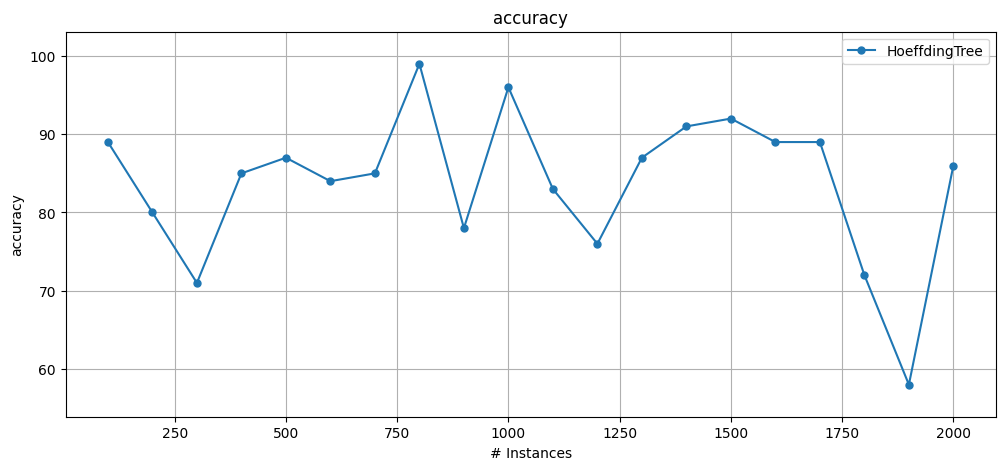

In [3]:
from capymoa.evaluation import prequential_evaluation
from capymoa.classifier import HoeffdingTree
from capymoa.datasets import ElectricityTiny
from capymoa.evaluation.visualization import plot_windowed_results

elec_stream = ElectricityTiny()
ht = HoeffdingTree(schema=elec_stream.get_schema(), grace_period=50)

results_ht = prequential_evaluation(
    stream=elec_stream,
    learner=ht,
    window_size=100,
    optimise=True,
    store_predictions=False,
    store_y=False,
)


print("\tDifferent ways of accessing metrics:")

print(
    f"results_ht['wallclock']: {results_ht['wallclock']} results_ht.wallclock(): {results_ht.wallclock()}"
)
print(
    f"results_ht['cpu_time']: {results_ht['cpu_time']} results_ht.cpu_time(): {results_ht.cpu_time()}"
)

print(f"results_ht.cumulative.accuracy() = {results_ht.cumulative.accuracy()}")
print(f"results_ht.cumulative['accuracy'] = {results_ht.cumulative['accuracy']}")
print(f"results_ht['cumulative'].accuracy() = {results_ht['cumulative'].accuracy()}")
print(f"results_ht.accuracy() = {results_ht.accuracy()}")

print("\n\tAll the cumulative results:")
print(results_ht.cumulative.metrics_dict())

print("\n\tAll the windowed results:")
display(results_ht.metrics_per_window())
# OR display(results_ht.windowed.metrics_per_window())

# results_ht.write_to_file() -> this will save the results to a directory

plot_windowed_results(results_ht, metric="accuracy")

### 2.4 Evaluating a single stream using multiple learners

```prequential_evaluation_multiple_learners()``` further encapsulates experiments by executing multiple learners on a single stream. 

* This function behaves as if we invoked ```prequential_evaluation()``` multiple times, but internally it only iterates through the Stream once. This is useful if we are faced with a situation where accessing each Instance of the Stream is costly this function will be more convenient than just invoking ```prequential_evaluation()``` multiple times. 

* This method does not calculate ```wallclock``` or ```cpu_time``` because the training and testing of each learner is interleaved, thus timing estimations are unreliable. Thus, the results dictionaries do not contain the keys ```wallclock``` and ```cpu_time```. 

OB final accuracy = 82.4174611581921 and ARF final accuracy = 89.32953742937853


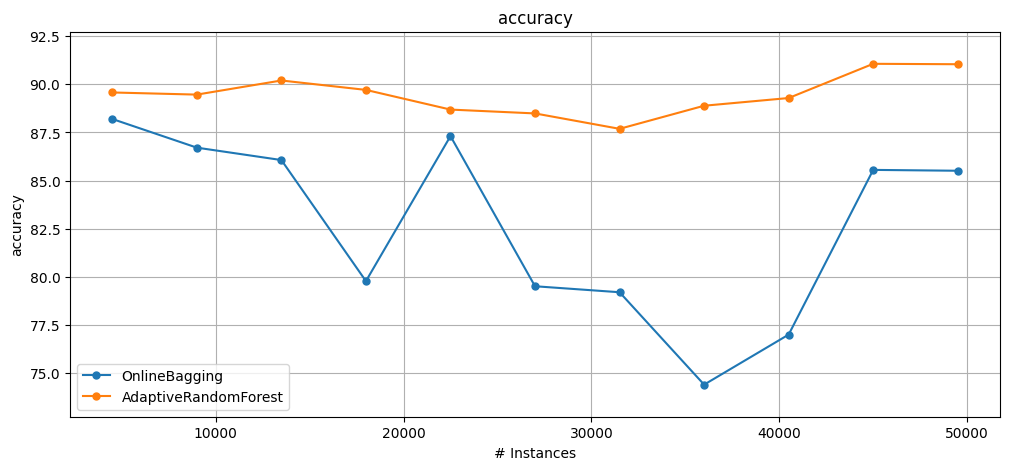

In [4]:
from capymoa.evaluation import prequential_evaluation_multiple_learners
from capymoa.datasets import Electricity
from capymoa.classifier import AdaptiveRandomForestClassifier, OnlineBagging
from capymoa.evaluation.visualization import plot_windowed_results

stream = Electricity()

# Define the learners + an alias (dictionary key)
learners = {
    "OB": OnlineBagging(schema=stream.get_schema(), ensemble_size=10),
    "ARF": AdaptiveRandomForestClassifier(schema=stream.get_schema(), ensemble_size=10),
}

results = prequential_evaluation_multiple_learners(stream, learners, window_size=4500)

print(
    f"OB final accuracy = {results['OB'].cumulative.accuracy()} and ARF final accuracy = {results['ARF'].cumulative.accuracy()}"
)
plot_windowed_results(results["OB"], results["ARF"], metric="accuracy")

## 3. Regression

* We introduce a simple example using regression just to show how similar it is to assess regressors using the **high-level evaluation functions**
* In the example below, we just use ```prequential_evaluation()``` but it would work with ```cumulative_evaluation()``` and ```windowed_evaluation()``` as well.
* One difference between Classification and Regression evaluation in CapyMOA is that the Evaluators are different. Instead of ```ClassificationEvaluator``` and ```ClassificationWindowedEvaluator``` functions use ```RegressionEvaluator``` and ```RegressionWindowedEvaluator```

kNNRegressor [cumulative] RMSE = 2.7229994765160916 and     AdaptiveRandomForestRegressor  [cumulative] RMSE = 2.3894271579519426


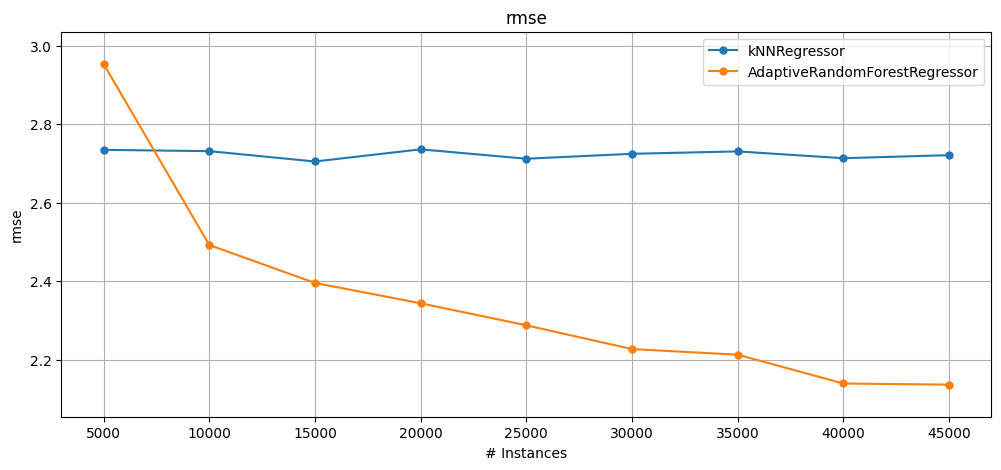

In [5]:
from capymoa.datasets import Fried
from capymoa.evaluation.visualization import plot_windowed_results
from capymoa.evaluation import prequential_evaluation
from capymoa.regressor import KNNRegressor, AdaptiveRandomForestRegressor

stream = Fried()
kNN_learner = KNNRegressor(schema=stream.get_schema(), k=5)
ARF_learner = AdaptiveRandomForestRegressor(
    schema=stream.get_schema(), ensemble_size=10
)

kNN_results = prequential_evaluation(
    stream=stream, learner=kNN_learner, window_size=5000
)
ARF_results = prequential_evaluation(
    stream=stream, learner=ARF_learner, window_size=5000
)

print(
    f"{kNN_results['learner']} [cumulative] RMSE = {kNN_results['cumulative'].rmse()} and \
    {ARF_results['learner']}  [cumulative] RMSE = {ARF_results['cumulative'].rmse()}"
)

plot_windowed_results(kNN_results, ARF_results, metric="rmse")

### 3.1 Evaluating a single stream using multiple learners (Regression)

* ```prequential_evaluation_multiple_learners``` also works for multiple regressors, the example below shows how it can be used. 

Cumulative results for each learner:
kNNReg_k5, RMSE: 2.72, adjusted R2: 0.70
kNNReg_k2, RMSE: 3.08, adjusted R2: 0.62
kNNReg_k5_median, RMSE: 2.94, adjusted R2: 0.65
ARFReg_s5, RMSE: 2.58, adjusted R2: 0.73


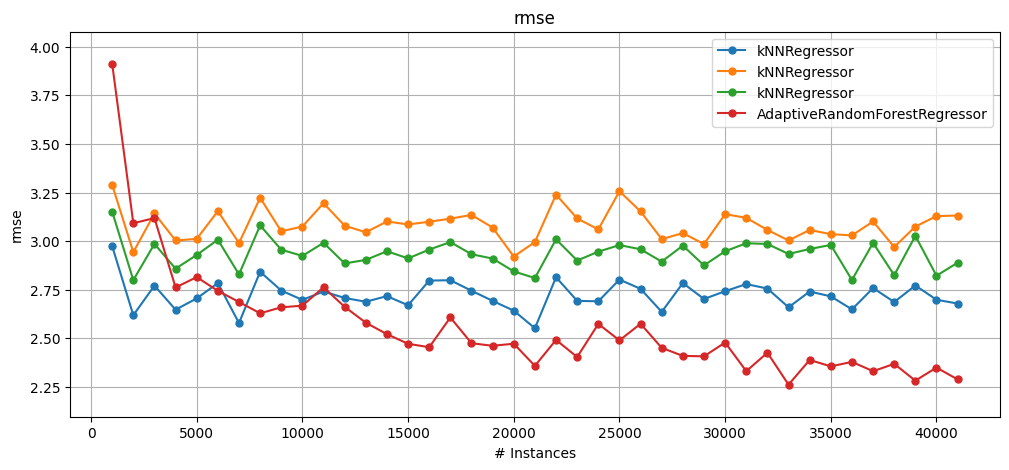

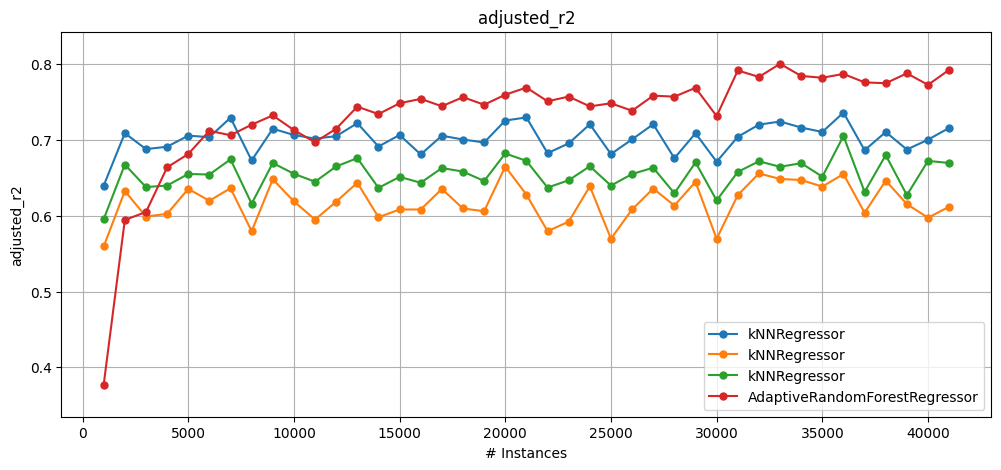

In [6]:
from capymoa.evaluation import prequential_evaluation_multiple_learners

# Define the learners + an alias (dictionary key)
learners = {
    "kNNReg_k5": KNNRegressor(schema=stream.get_schema(), k=5),
    "kNNReg_k2": KNNRegressor(schema=stream.get_schema(), k=2),
    "kNNReg_k5_median": KNNRegressor(schema=stream.get_schema(), CLI="-k 5 -m"),
    "ARFReg_s5": AdaptiveRandomForestRegressor(
        schema=stream.get_schema(), ensemble_size=5
    ),
}

results = prequential_evaluation_multiple_learners(stream, learners)

print("Cumulative results for each learner:")
for learner_id in learners.keys():
    if learner_id in results:
        cumulative = results[learner_id]["cumulative"]
        print(
            f"{learner_id}, RMSE: {cumulative.rmse():.2f}, adjusted R2: {cumulative.adjusted_r2():.2f}"
        )

# Tip: invoking metrics_header() from an Evaluator will show us all the metrics available,
# e.g. results['kNNReg_k5']['cumulative'].metrics_header()
plot_windowed_results(
    results["kNNReg_k5"],
    results["kNNReg_k2"],
    results["kNNReg_k5_median"],
    results["ARFReg_s5"],
    metric="rmse",
)

plot_windowed_results(
    results["kNNReg_k5"],
    results["kNNReg_k2"],
    results["kNNReg_k5_median"],
    results["ARFReg_s5"],
    metric="adjusted_r2",
)

### 3.2 Plotting predictions vs. ground truth over time (Regression)

* In Regression it is sometimes desirable to plot **predictions vs. ground truth** to observe what is happening with the Stream. If we create a custom loop and use the Evaluators directly it is trivial to store the ground truth and predictions, and then proceed to plot them. However, to make people's life easier ```plot_predictions_vs_ground_truth``` function can be used.

* For massive streams with millions of instances it can be unbearable to plot all at once, thus we can specify a ```plot_interval``` (that we want to investigate) to ```plot_predictions_vs_ground_truth```. By default, the plot function will attempt to plot everything, i.e. if ```plot_interval=None```, which is seldom a good idea. 

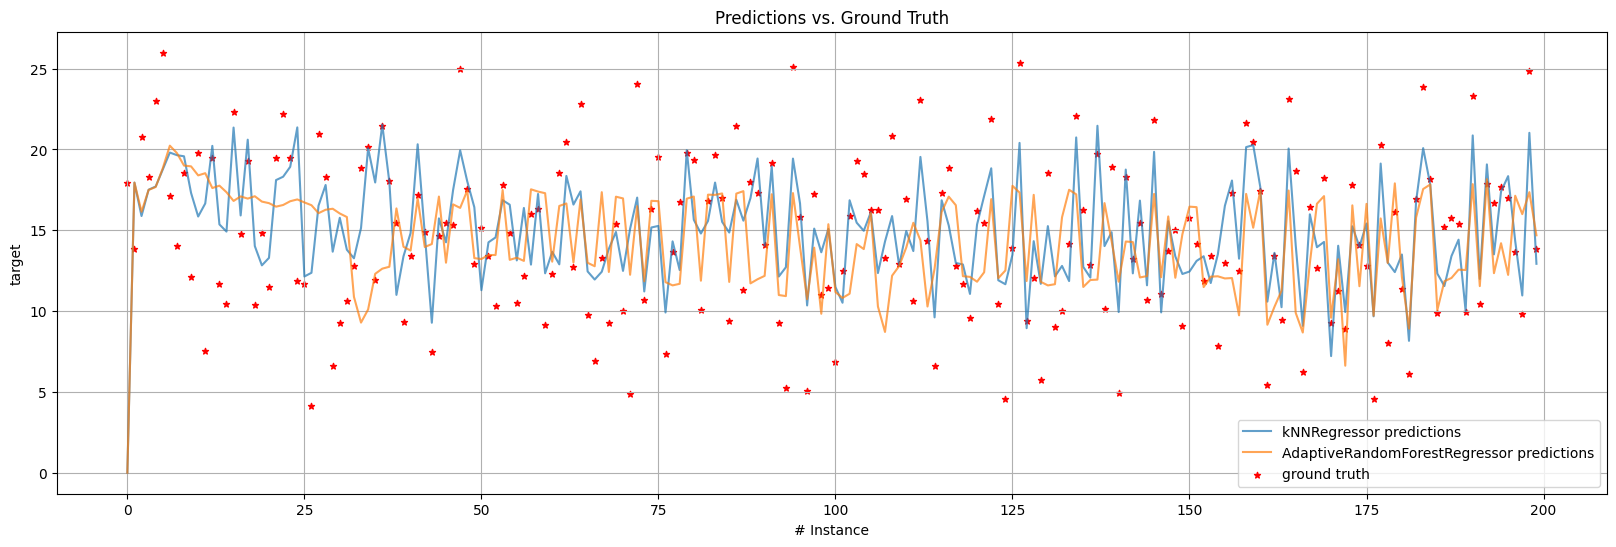

In [7]:
from capymoa.evaluation import prequential_evaluation
from capymoa.evaluation.visualization import plot_predictions_vs_ground_truth
from capymoa.regressor import KNNRegressor, AdaptiveRandomForestRegressor
from capymoa.datasets import Fried

stream = Fried()
kNN_learner = KNNRegressor(schema=stream.get_schema(), k=5)
ARF_learner = AdaptiveRandomForestRegressor(
    schema=stream.get_schema(), ensemble_size=10
)

# When we specify store_predictions and store_y, the results will also include all the predictions and all the ground truth y.
# It is useful for debugging and outputting the predictions elsewhere.
kNN_results = prequential_evaluation(
    stream=stream,
    learner=kNN_learner,
    window_size=5000,
    store_predictions=True,
    store_y=True,
)
# We don't need to store the ground-truth for every experiment, since it is always the same for the same stream
ARF_results = prequential_evaluation(
    stream=stream, learner=ARF_learner, window_size=5000, store_predictions=True
)


# Plot only 200 predictions (see plot_interval)
plot_predictions_vs_ground_truth(
    kNN_results,
    ARF_results,
    ground_truth=kNN_results["ground_truth_y"],
    plot_interval=(0, 200),
)